### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import BertTokenizer #, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
import json
import os

os.environ["WANDB_DISABLED"] = "true"

C:\Users\sejeo\anaconda3\envs\python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Random Seeds

In [2]:
import random
from transformers import set_seed

# Set the random seed for reproducibility
seed = 42  # You can use any integer value
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
set_seed(seed)  # For transformers

### Load dataset

Condition
- 0: F2F
- 1: Online

In [3]:
# Transcript and prediction targets
video_path = "E:/GAR/videos"
df = {rnd: pd.read_csv(os.path.join(video_path, f"G4_{rnd}_tsrc_whisper.csv")) for rnd in ['R1', 'R2', 'R3']}

# Some F2F courses were mistakenly recorded as Online Courses
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Cotulla David Rodriguez Day 1 weather', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Jim Hogg Aaron Salazar Week 3 Day 1.mp4', 'Condition'] = 0
df['R1'].loc[df['R1']['Video names'] == 'G4 Online Kopperl Debbie Beavers', 'Condition'] = 0

### Define the functions

In [4]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    precision = precision_score(labels, predictions, average='weighted', zero_division=1)
    recall = recall_score(labels, predictions, average='weighted', zero_division=1)
    f1 = f1_score(labels, predictions, average='weighted')
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [5]:
from datasets import Dataset
import joblib

def tokenize_and_save(df, target, rnd, setting, video_path, results_dir, dataset_dir):
    
    # df = df[rnd]
    df = df[df['Condition'] == setting][['tsrc', target]]
    df = df.fillna(' ')

    # Encode the target column
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[target])
    
    # Save the label mapping to a JSON file
    label_mapping = {index: str(label) for index, label in enumerate(label_encoder.classes_)}
    mapping_file_path = os.path.join(results_dir, "encoded_to_original_label.json")
    with open(mapping_file_path, "w") as json_file:
        json.dump(label_mapping, json_file, indent=4)
    print(f"Label mapping saved to: {mapping_file_path}")
    
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    
    def tokenize_function(example):
        return tokenizer(example["tsrc"], truncation=True, padding="max_length", max_length=128)

    # Split dataset
    train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)
    
    for split, dataset in zip(["train", "val", "test"], [train_df, val_df, test_df]):
        dataset = Dataset.from_pandas(dataset)  # Convert DataFrame to Dataset
        dataset = dataset.map(tokenize_function, batched=True)  # Now `batched=True` works
        dataset = dataset.remove_columns(["tsrc"])
        dataset.set_format("numpy")
        joblib.dump(dataset, os.path.join(dataset_dir, f"{split}_dataset.joblib"))

    tokenizer.save_pretrained(results_dir)  # Save tokenizer
    
    return df

In [6]:
!pip install xgboost

In [7]:
import xgboost as xgb

def training_evaluation(video_path, results_dir, output_dir):
    
    # Load tokenized datasets
    train_dataset = joblib.load(os.path.join(dataset_dir, "train_dataset.joblib"))
    val_dataset = joblib.load(os.path.join(dataset_dir, "val_dataset.joblib"))
    test_dataset = joblib.load(os.path.join(dataset_dir, "test_dataset.joblib"))
    
    train_features, train_labels = np.array(train_dataset["input_ids"].tolist()), np.array(train_dataset["label"].tolist())
    val_features, val_labels = np.array(val_dataset["input_ids"].tolist()), np.array(val_dataset["label"].tolist())
    test_features, test_labels = np.array(test_dataset["input_ids"].tolist()), np.array(test_dataset["label"].tolist())

    label_encoder = LabelEncoder()
    all_labels = np.concatenate([train_labels, val_labels, test_labels])
    label_encoder.fit(all_labels)

    train_labels = label_encoder.transform(train_labels)
    val_labels = label_encoder.transform(val_labels)
    test_labels = label_encoder.transform(test_labels)

    print(np.sort(np.unique(train_labels)))
    print(np.sort(np.unique(val_labels)))
    print(np.sort(np.unique(test_labels)))
    
    # Save the label mapping to a JSON file
    label_mapping = {index: str(label) for index, label in enumerate(label_encoder.classes_)}
    print(label_mapping)
    mapping_file_path = os.path.join(results_dir, "encoded_to_original_label.json")
    with open(mapping_file_path, "w") as json_file:
        json.dump(label_mapping, json_file, indent=4)
    print(f"Label mapping saved to: {mapping_file_path}")

    # Train XGBoost Model
    xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=20, random_state=42)
    xgb_model.fit(train_features, train_labels)
    
    # Save the trained model using joblib's dump function
    joblib.dump(xgb_model, os.path.join(output_dir, "xgboost_model.joblib"))
    
    # Evaluate Model
    predictions = xgb_model.predict(test_features)
    metrics = {
        "accuracy": accuracy_score(test_labels, predictions),
        "precision": precision_score(test_labels, predictions, average="weighted", zero_division=1),
        "recall": recall_score(test_labels, predictions, average="weighted", zero_division=1),
        "f1": f1_score(test_labels, predictions, average="weighted")
    }
    with open(os.path.join(results_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)
    
    # Get the encoded labels that appear in the confusion matrix
    unique_labels = sorted(set(test_labels) | set(predictions))
    print(unique_labels)
    
    # Convert label indices back to original labels using label_mapping
    original_labels = [label_mapping[label] for label in unique_labels]
    print(original_labels)
    
    # Display and save the confusion matrix with original labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=original_labels)
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("Confusion Matrix")
    plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))
    plt.show()
    plt.close()
    
    print("Evaluation Metrics:", metrics)





---------------------- Tokenize and save dataset R123, Setting 0, ESL Strategy ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/ESL Strategy\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2386.96 examples/s]


[0 1 2 3 4 5 6 7 8]
[1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'}
Label mapping saved to: ./results0227_xgb/R123/0/ESL Strategy\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
['0', '1', '2', '3', '4', '5', '6', '7', '8']


<Figure size 1000x800 with 0 Axes>

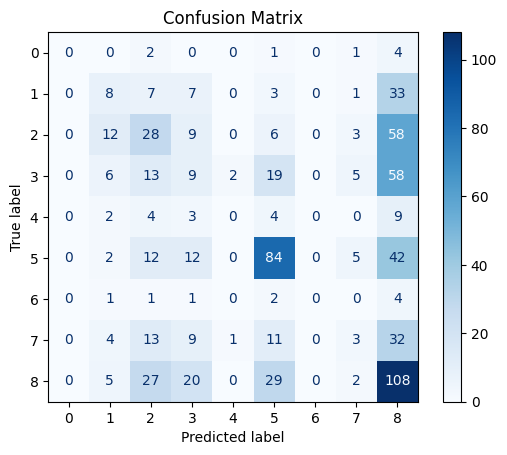

Evaluation Metrics: {'accuracy': 0.321285140562249, 'precision': 0.3035132509803166, 'recall': 0.321285140562249, 'f1': 0.2870978544516411}



---------------------- Tokenize and save dataset R123, Setting 0, Curriculum ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/Curriculum\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2208.33 examples/s]


[0 1 2 3]
[0 2]
[0 1 2]
{0: '0', 1: '1', 2: '2', 3: '3'}
Label mapping saved to: ./results0227_xgb/R123/0/Curriculum\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2)]
['0', '1', '2']


<Figure size 1000x800 with 0 Axes>

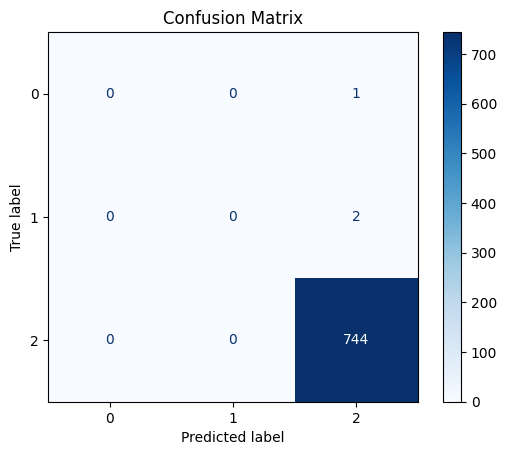

Evaluation Metrics: {'accuracy': 0.9959839357429718, 'precision': 0.9960000645150885, 'recall': 0.9959839357429718, 'f1': 0.9939799439205513}



---------------------- Tokenize and save dataset R123, Setting 0, Physical Group ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/Physical Group\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2236.97 examples/s]


[0 1 2 3 4]
[0 1 2 3 4]
[0 1 2 3 4]
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
Label mapping saved to: ./results0227_xgb/R123/0/Physical Group\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
['0', '1', '2', '3', '4']


<Figure size 1000x800 with 0 Axes>

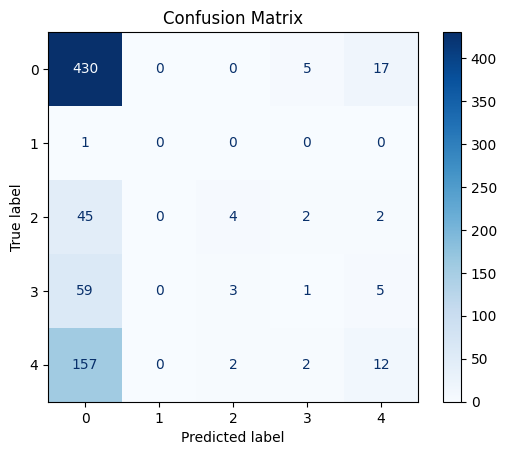

Evaluation Metrics: {'accuracy': 0.5983935742971888, 'precision': 0.4951663644515979, 'recall': 0.5983935742971888, 'f1': 0.49295654339940137}



---------------------- Tokenize and save dataset R123, Setting 0, Activity Structure ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/Activity Structure\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2488.88 examples/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17'}
Label mapping saved to: ./results0227_xgb/R123/0/Activity Structure\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17']


<Figure size 1000x800 with 0 Axes>

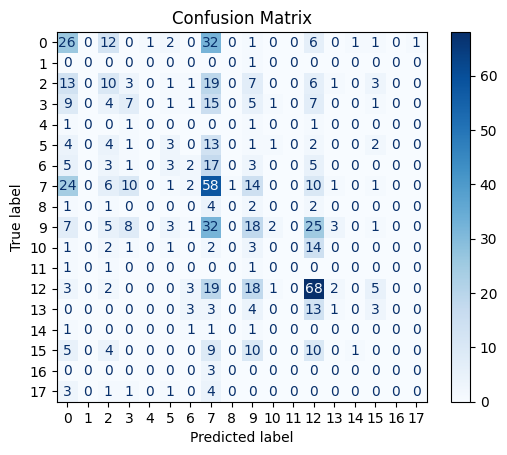

Evaluation Metrics: {'accuracy': 0.2583668005354752, 'precision': 0.22327763413259244, 'recall': 0.2583668005354752, 'f1': 0.22525969350693442}



---------------------- Tokenize and save dataset R123, Setting 0, Mode ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/Mode\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2535.67 examples/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  2  4  5  6  7  8  9 10 11 12 13 14 15 16]
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16'}
Label mapping saved to: ./results0227_xgb/R123/0/Mode\encoded_to_original_label.json
[np.int64(0), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]
['0', '2', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16']


<Figure size 1000x800 with 0 Axes>

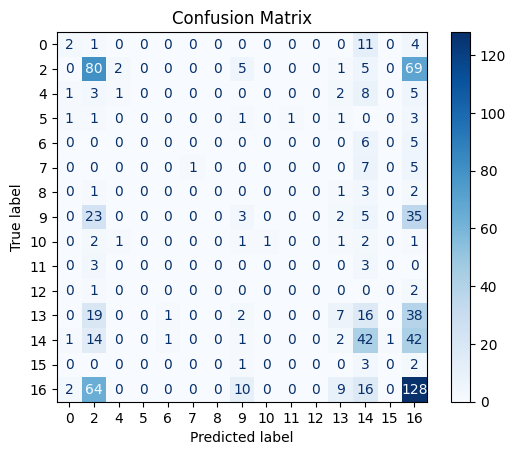

Evaluation Metrics: {'accuracy': 0.35475234270414996, 'precision': 0.35137045720165405, 'recall': 0.35475234270414996, 'f1': 0.3122774565604347}



---------------------- Tokenize and save dataset R123, Setting 0, Language Content ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/Language Content\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2567.34 examples/s]


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
{0: '0', 1: '1', 2: '2', 3: '3'}
Label mapping saved to: ./results0227_xgb/R123/0/Language Content\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['0', '1', '2', '3']


<Figure size 1000x800 with 0 Axes>

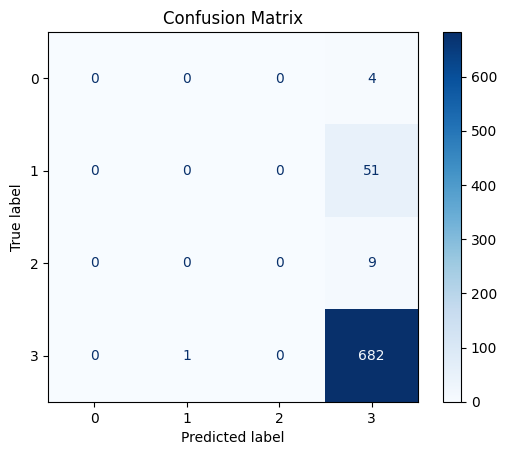

Evaluation Metrics: {'accuracy': 0.9129852744310576, 'precision': 0.8532862459668882, 'recall': 0.9129852744310576, 'f1': 0.8727346990012769}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/Lang. of Instruction(T)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2417.34 examples/s]


[0 1 2]
[0 1 2]
[0 1 2]
{0: '0', 1: '1', 2: '2'}
Label mapping saved to: ./results0227_xgb/R123/0/Lang. of Instruction(T)\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2)]
['0', '1', '2']


<Figure size 1000x800 with 0 Axes>

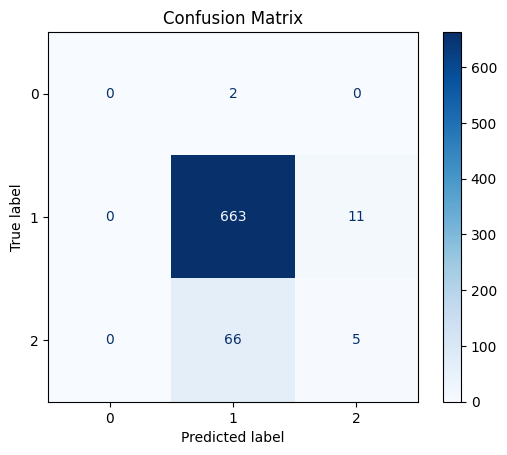

Evaluation Metrics: {'accuracy': 0.8942436412315931, 'precision': 0.850722658074157, 'recall': 0.8942436412315931, 'f1': 0.8624677518653718}



---------------------- Tokenize and save dataset R123, Setting 0, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_xgb/R123/0/Lang. of Instruction(S)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 747/747 [00:00<00:00, 2411.59 examples/s]


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
{0: '0', 1: '1', 2: '2', 3: '3'}
Label mapping saved to: ./results0227_xgb/R123/0/Lang. of Instruction(S)\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['0', '1', '2', '3']


<Figure size 1000x800 with 0 Axes>

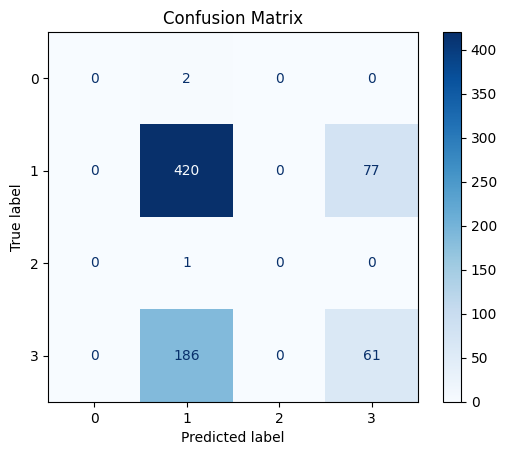

Evaluation Metrics: {'accuracy': 0.643908969210174, 'precision': 0.6090224633332598, 'recall': 0.643908969210174, 'f1': 0.6100916791171481}



---------------------- Tokenize and save dataset R123, Setting 1, ESL Strategy ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/ESL Strategy\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 1372.49 examples/s]


[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
[0 1 2 3 4 5 6 7 8]
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'}
Label mapping saved to: ./results0227_xgb/R123/1/ESL Strategy\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
['0', '1', '2', '3', '4', '5', '6', '7', '8']


<Figure size 1000x800 with 0 Axes>

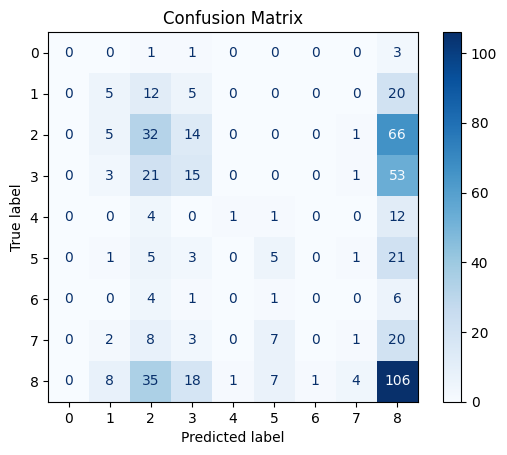

Evaluation Metrics: {'accuracy': 0.30275229357798167, 'precision': 0.28036162454515634, 'recall': 0.30275229357798167, 'f1': 0.26460944135249564}



---------------------- Tokenize and save dataset R123, Setting 1, Curriculum ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/Curriculum\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 2328.90 examples/s]


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
{0: '0', 1: '1', 2: '2', 3: '3'}
Label mapping saved to: ./results0227_xgb/R123/1/Curriculum\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['0', '1', '2', '3']


<Figure size 1000x800 with 0 Axes>

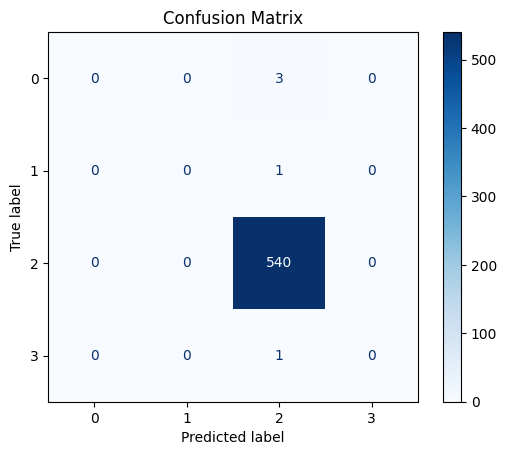

Evaluation Metrics: {'accuracy': 0.9908256880733946, 'precision': 0.9909098560727212, 'recall': 0.9908256880733946, 'f1': 0.9862596710776644}



---------------------- Tokenize and save dataset R123, Setting 1, Physical Group ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/Physical Group\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 2298.32 examples/s]


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
{0: '0', 1: '1', 2: '2', 3: '3'}
Label mapping saved to: ./results0227_xgb/R123/1/Physical Group\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['0', '1', '2', '3']


<Figure size 1000x800 with 0 Axes>

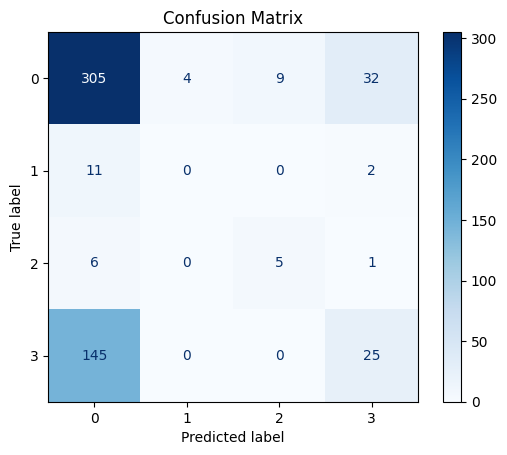

Evaluation Metrics: {'accuracy': 0.6146788990825688, 'precision': 0.5572582961243747, 'recall': 0.6146788990825688, 'f1': 0.5557684693197058}



---------------------- Tokenize and save dataset R123, Setting 1, Activity Structure ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/Activity Structure\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 2333.15 examples/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16'}
Label mapping saved to: ./results0227_xgb/R123/1/Activity Structure\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']


<Figure size 1000x800 with 0 Axes>

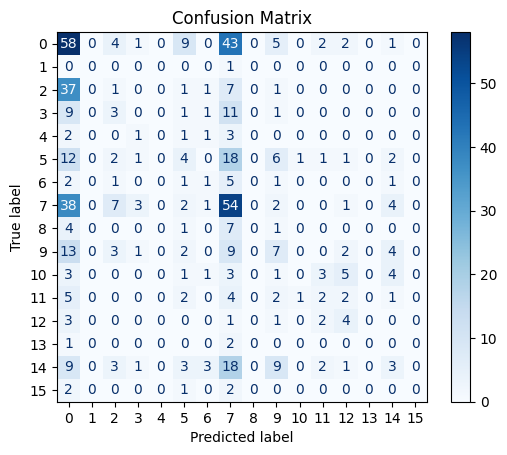

Evaluation Metrics: {'accuracy': 0.24587155963302754, 'precision': 0.23836378942842693, 'recall': 0.24587155963302754, 'f1': 0.20156559208115726}



---------------------- Tokenize and save dataset R123, Setting 1, Mode ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/Mode\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 2243.45 examples/s]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17'}
Label mapping saved to: ./results0227_xgb/R123/1/Mode\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17)]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17']


<Figure size 1000x800 with 0 Axes>

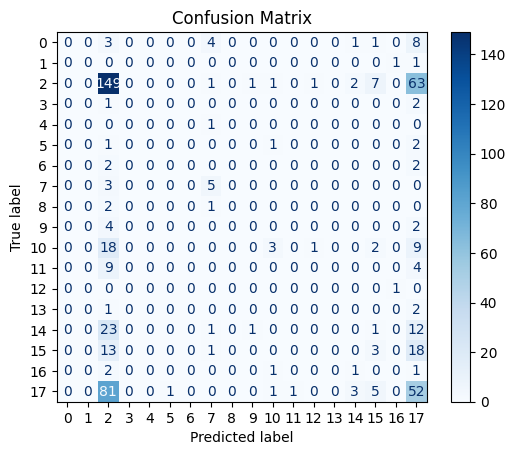

Evaluation Metrics: {'accuracy': 0.3889908256880734, 'precision': 0.37623055889308954, 'recall': 0.3889908256880734, 'f1': 0.3373300999834304}



---------------------- Tokenize and save dataset R123, Setting 1, Language Content ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/Language Content\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 2256.34 examples/s]


[0 1 2 3]
[0 1 2 3]
[0 1 2 3]
{0: '0', 1: '1', 2: '2', 3: '3'}
Label mapping saved to: ./results0227_xgb/R123/1/Language Content\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
['0', '1', '2', '3']


<Figure size 1000x800 with 0 Axes>

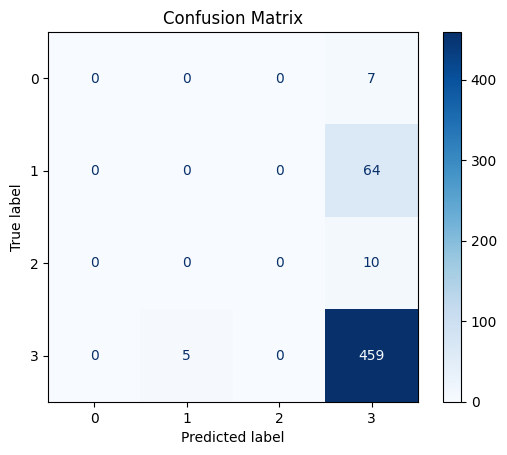

Evaluation Metrics: {'accuracy': 0.8422018348623853, 'precision': 0.7548623853211008, 'recall': 0.8422018348623853, 'f1': 0.7784495047333602}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(T) ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/Lang. of Instruction(T)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 2281.42 examples/s]


[0 1 2]
[0 1 2]
[0 1 2]
{0: '0', 1: '1', 2: '2'}
Label mapping saved to: ./results0227_xgb/R123/1/Lang. of Instruction(T)\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(2)]
['0', '1', '2']


<Figure size 1000x800 with 0 Axes>

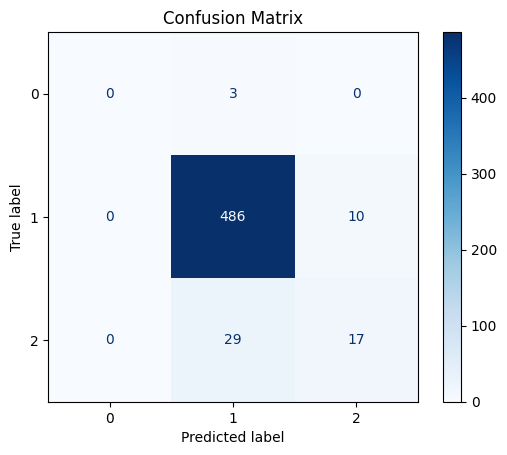

Evaluation Metrics: {'accuracy': 0.9229357798165138, 'precision': 0.9125174978385988, 'recall': 0.9229357798165138, 'f1': 0.9117069336440766}



---------------------- Tokenize and save dataset R123, Setting 1, Lang. of Instruction(S) ----------------------
Label mapping saved to: ./results0227_xgb/R123/1/Lang. of Instruction(S)\encoded_to_original_label.json


Map: 100%|██████████████████████████████████████████████████████████████████| 545/545 [00:00<00:00, 2234.79 examples/s]


[0 1 2 3]
[0 1 2 3]
[0 1 3]
{0: '0', 1: '1', 2: '2', 3: '3'}
Label mapping saved to: ./results0227_xgb/R123/1/Lang. of Instruction(S)\encoded_to_original_label.json
[np.int64(0), np.int64(1), np.int64(3)]
['0', '1', '3']


<Figure size 1000x800 with 0 Axes>

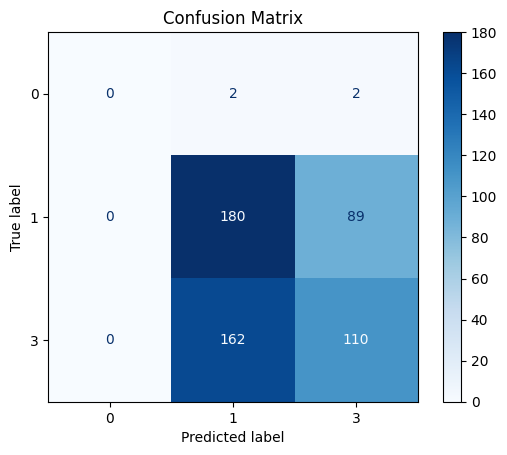

Evaluation Metrics: {'accuracy': 0.5321100917431193, 'precision': 0.5387367621037122, 'recall': 0.5321100917431193, 'f1': 0.5219977787298943}


In [22]:
data = list(df.keys())
settings = [0, 1]
y_cols = ['ESL Strategy', 'Curriculum', 'Physical Group',
          'Activity Structure', 'Mode', 'Language Content',
          'Lang. of Instruction(T)', 'Lang. of Instruction(S)']

df_merged = pd.concat([df['R1'], df['R2'], df['R3']])
df_merged = df_merged.reset_index(drop=True)

# print(df_merged['ESL Strategy'].value_counts())
# Drop 'ESL Strategy' == 'L1 clarification' since there is only one row
df_merged = df_merged[df_merged['ESL Strategy'] != 8]

df_merged = df_merged[~df_merged['Activity Structure'].isin([14, 16, 20])]
df_merged = df_merged[~((df_merged['Condition']==1) & (df_merged['Activity Structure']==12))]

df_merged = df_merged[~df_merged['Lang. of Instruction(T)'].isin([3, 4])]

df_merged = df_merged[df_merged['Curriculum'] != 3]

for rnd in ['R123']:
    for setting in settings:
        for target in y_cols:
            print(f"\n\n\n---------------------- Tokenize and save dataset {rnd}, Setting {setting}, {target} ----------------------")

            dataset_dir = f"./datasets0227_xgb/{rnd}/{setting}/{target}"
            output_dir = f"./models0227_xgb/{rnd}/{setting}/{target}"
            results_dir = f"./results0227_xgb/{rnd}/{setting}/{target}"
            os.makedirs(dataset_dir, exist_ok=True)
            os.makedirs(output_dir, exist_ok=True)
            os.makedirs(results_dir, exist_ok=True)

            tokenize_and_save(df_merged, target, rnd, setting, video_path, results_dir, dataset_dir)
            training_evaluation(video_path, results_dir, output_dir)